In [105]:
import tensorflow as tf
import numpy as np
import keras
from PIL import Image
import os
import matplotlib.pyplot as plt

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
from PIL import Image
import random

In [116]:
class CustomDataGen(keras.utils.Sequence):
    def __init__(self, data_folder: str, aug_len: dict[str, float], batch_size=32, workers=1, use_multiprocessing=False, max_queue_size=10):
        super().__init__(workers, use_multiprocessing, max_queue_size)

        self.data_folder = data_folder
        self.aug_len = aug_len
        self.batch_size = batch_size
        self.data = []

        self.pipeline = tf.keras.Sequential([
            keras.layers.RandomFlip("horizontal_and_vertical"),
            keras.layers.RandomRotation(0.2),
            keras.layers.RandomZoom(0.1),
            keras.layers.RandomContrast(0.01),
            keras.layers.Rescaling(1./255),
            keras.layers.Normalization(
                mean=(0.485, 0.456, 0.406), 
                variance=(0.229, 0.224, 0.225)
            )
        ])

        self.load_data()

        random.shuffle(self.data)
    
    def load_data(self):
        for root, _, files in os.walk(self.data_folder):
            for file in files:
                subfolder = os.path.basename(root)
                if subfolder in self.aug_len:
                    prob = self.aug_len[subfolder]
                    for _ in range(int(prob)):
                        self.data.append({
                            "path": os.path.join(root, file),
                            "label": subfolder
                        })
                    if np.random.rand() < (prob - int(prob)):
                        self.data.append({
                            "path": os.path.join(root, file),
                            "label": subfolder
                        })
                else:
                    self.data.append({
                        "path": os.path.join(root, file),
                        "label": subfolder
                    })

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_data = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []
        for item in batch_data:
            img = Image.open(item["path"])
            img = np.array(img)
            img = self.pipeline(img)
            batch_images.append(img)
            batch_labels.append(item["label"])
        return np.array(batch_images), np.array(batch_labels)
    
    def on_epoch_end(self):
        self.load_data()
        random.shuffle(self.data)


In [117]:
data = CustomDataGen(
    "/home/shared/Mammiferes_resized",
    {"Castor": 1.5, "Chien": 1.5})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9550355..1.0817704].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8534681..1.0761913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9573996..1.2317238].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.83422536..1.1381195].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.60191596..1.04856].


(32, 256, 256, 3)


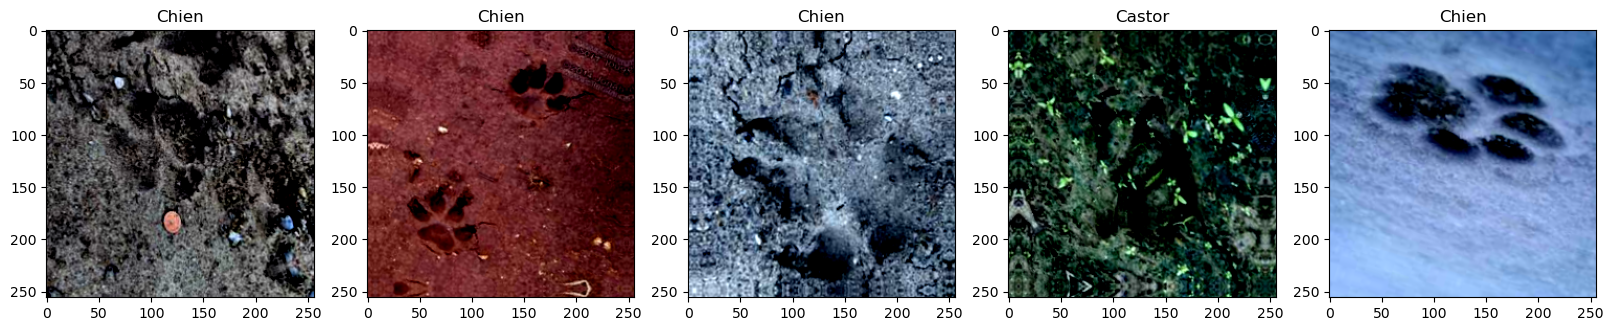

In [118]:
batch= next(iter(data))
print(batch[0].shape)

plt.figure(figsize=(20, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(batch[0][i])
    plt.title(batch[1][i])
    